In [118]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# get data from xlsx file
def get_data_from_xlsx(file_path):
    """
    Reads data from an Excel file and returns a DataFrame.
    
    Args:
        file_path (str): Path to the Excel file.s
        
    Returns:
        pd.DataFrame: DataFrame containing the data from the Excel file.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name=None)
    
    # Concatenate all sheets into a single DataFrame
    all_data = pd.concat(df.values(), ignore_index=True)
    
    return all_data
# get data from csv file

dataset_org = get_data_from_xlsx('credit_score_mn.xlsx')

In [ ]:
# change Label_loan_grade column values to 0 to 5. its format like ("Zeel: A", "Zeel: B", "Zeel: C", "Zeel: D", "Zeel: E", "Zeel: F")
def convert_loan_grade(loan_grade):
    """
    Converts loan grade labels to numerical values.
    
    Args:
        loan_grade (str): Loan grade label (e.g., "Zeel: A").
        
    Returns:
        int: Numerical value corresponding to the loan grade.
    """
    if pd.isna(loan_grade):
        return 55
    a = loan_grade.split(": ")
    if len(a) < 2:
        value = a[0]
    else:
        value = a[1]

    value = int(ord(value) - int(ord('A')))
    return value # if value < 4 else 4

# dataset = dataset.drop(columns=[
#     'person_age', 
#     'Зээлийн Оноо: Employment_length(in_years)',
#     # 'loan_percent_income',
#     # 'annual_person_income',
#     # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
#     'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
#     # 'loan_amount',
#     # 'loan_status (0 is non default 1 is default)',
#     # 'Historical_default(0=No,1=Yes)',
#     'Credit_history_length( max 10 )',
# ])

# print max Label_loan_grade
print(dataset_org['Label_loan_grade'].max())
print(dataset_org['Label_loan_grade'].min())
dataset = dataset_org.copy()
dataset['Label_loan_grade'] = dataset['Label_loan_grade'].apply(convert_loan_grade)


# drop columns that are not needed



test_dataset= dataset_org[-200:]
dataset = dataset_org[:-200]



6
0


AttributeError: 'int' object has no attribute 'split'

Best LogisticIT Parameters: {'alpha': 1.0, 'max_iter': 100}
Ordinal Logistic Regression:
Accuracy: 0.83
MAE: 0.18
MSE: 0.22

XGBoost:
Accuracy: 0.92
MAE: 0.10
MSE: 0.15


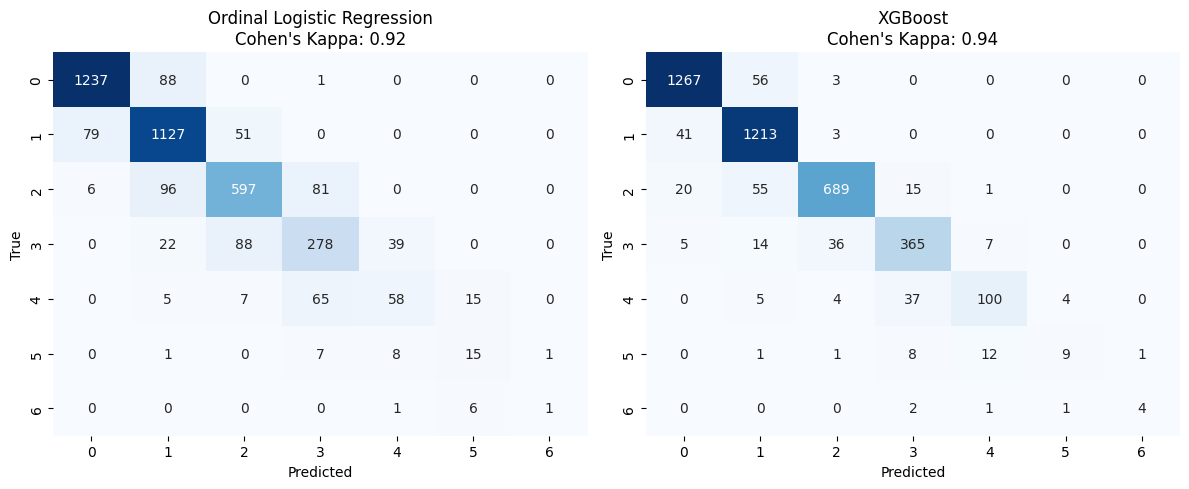

In [120]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from mord import LogisticIT  # For ordinal logistic regression
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
ds = dataset.copy()
ds = ds.drop(columns=[
    # 'person_age', 
    # 'Зээлийн Оноо: Employment_length(in_years)',
    # 'loan_percent_income',
    # 'annual_person_income',
    # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    # 'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    # 'loan_amount',
    # 'loan_status (0 is non default 1 is default)',
    # 'Historical_default(0=No,1=Yes)',
    # 'Credit_history_length( max 10 )',
])

# drop columns that are not needed
X = ds.drop(columns=['Label_loan_grade'])
y = ds['Label_loan_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Approach 1: Ordinal Logistic Regression (using mord)
ordinal_model = LogisticIT()  # LogisticIT is an ordinal regression model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

param_grid = {
    'alpha': [0.0, 0.1, 1.0, 10.0],  # Regularization strength
    'max_iter': [100, 500, 1000]     # Maximum iterations
}
grid_search = GridSearchCV(
    ordinal_model, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_logistic_it = grid_search.best_estimator_
print("Best LogisticIT Parameters:", grid_search.best_params_)

ordinal_model.fit(X_train_scaled, y_train)
y_pred_ordinal = ordinal_model.predict(X_test_scaled)


# Evaluate
print("Ordinal Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ordinal):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ordinal):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ordinal):.2f}")
cm_ordinal = confusion_matrix(y_test, y_pred_ordinal)
kappa_ordinal = cohen_kappa_score(y_test, y_pred_ordinal, weights='quadratic')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)


# Approach 2: XGBoost with ordinal target
xgb_model = xgb.XGBClassifier(objective='reg:logistic', eval_metric='mae')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)



print("\nXGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")

# Confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)


# Weighted Cohen's kappa (quadratic weights for ordinal errors)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb, weights='quadratic')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_ordinal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Ordinal Logistic Regression\nCohen\'s Kappa: {kappa_ordinal:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'XGBoost\nCohen\'s Kappa: {kappa_xgb:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [121]:
td = test_dataset.copy()
tdp = td.drop(columns=['Label_loan_grade'])
td_poly = poly.transform(tdp)
td_scaled = scaler.transform(td_poly)
y_pred_xgb = xgb_model.predict(td_scaled)

for i, label in enumerate(y_pred_xgb):
    # add predictions to test_dataset
    td.loc[test_dataset.index[i], 'Predicted_Label_loan_grade'] = label
    if label != td.loc[test_dataset.index[i], 'Label_loan_grade']:
        print(f"Predicted: {label}, Actual: {td.loc[test_dataset.index[i], 'Label_loan_grade']}")


td[['Label_loan_grade', 'Predicted_Label_loan_grade']].to_csv('predictions.csv', index=False)

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 3, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 3, Actual: 5
Predicted: 3, Actual: 4
Predicted: 3, Actual: 2


Best LogisticIT Parameters: {'model__alpha': 0.0, 'model__max_iter': 500, 'poly__degree': 2, 'poly__interaction_only': False}
Ordinal Logistic Regression:
Accuracy: 0.83
MAE: 0.18
MSE: 0.21

XGBoost:
Accuracy: 0.91
MAE: 0.10
MSE: 0.15


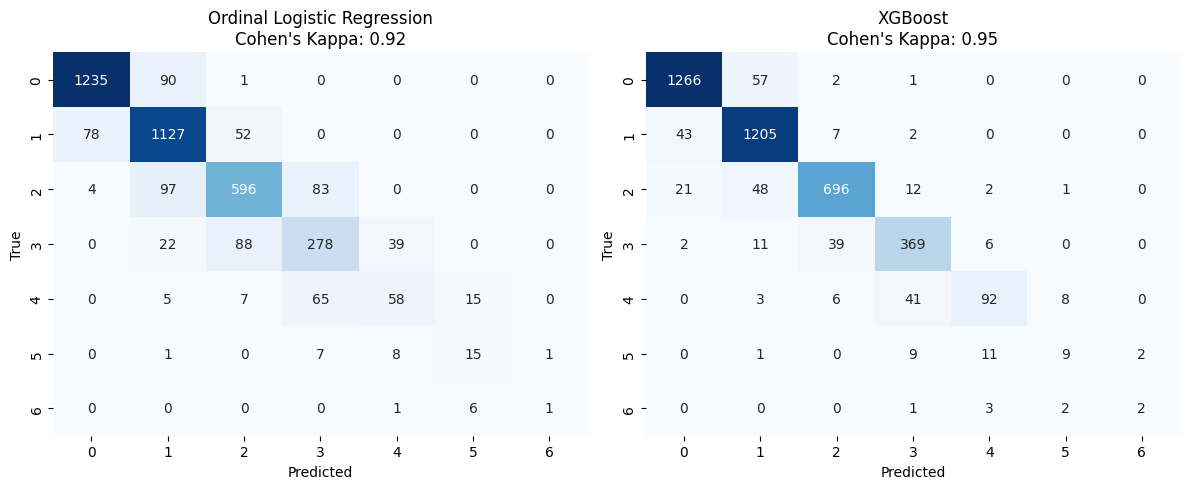

In [122]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from mord import LogisticIT, LogisticAT  # For ordinal logistic regression
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
ds = dataset.copy()

ds = ds.drop(columns=[
    # 'person_age', 
    # 'Зээлийн Оноо: Employment_length(in_years)',
    # 'loan_percent_income',
    # 'annual_person_income',
    # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    # 'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    # 'loan_amount',
    # 'loan_status (0 is non default 1 is default)',
    # 'Historical_default(0=No,1=Yes)',
    # 'Credit_history_length( max 10 )',
])

contiuous_columns = [
    'loan_interest_rate',
    'person_age',
    'Зээлийн Оноо: Employment_length(in_years)',
    'loan_percent_income',
    'annual_person_income',
    'loan_amount',
    'Credit_history_length( max 10 )',

    # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    # 'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    # 'loan_status (0 is non default 1 is default)',
    # 'Historical_default(0=No,1=Yes)',
]

categorical_columns = [
    'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    'loan_status (0 is non default 1 is default)',
    'Historical_default(0=No,1=Yes)'
]

# drop columns that are not needed
X = ds.drop(columns=['Label_loan_grade'])
y = ds['Label_loan_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), contiuous_columns),  # Scale numerical columns
        ('cat', 'passthrough', categorical_columns)    # Leave categorical columns unchanged
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('model', LogisticIT())
])

# Approach 1: Ordinal Logistic Regression (using mord)


param_grid = {
    'model__alpha': [0.0, 0.1],  # , 1.0, 10.0 Regularization strength
    'model__max_iter': [100, 500, 1000],    # Maximum iterations
    'poly__degree': [1, 2],                 # Test polynomial degrees
    'poly__interaction_only': [False, True] # Test interaction-only polynomials
}
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best LogisticIT Parameters:", grid_search.best_params_)

y_pred_ordinal = best_model.predict(X_test)

# Evaluate
print("Ordinal Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ordinal):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ordinal):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ordinal):.2f}")
cm_ordinal = confusion_matrix(y_test, y_pred_ordinal)
kappa_ordinal = cohen_kappa_score(y_test, y_pred_ordinal, weights='quadratic')

# Approach 2: XGBoost with ordinal target

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('xgb', xgb.XGBClassifier(objective='reg:logistic', eval_metric='mae'))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)



print("\nXGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")

# Confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)


# Weighted Cohen's kappa (quadratic weights for ordinal errors)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb, weights='quadratic')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_ordinal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Ordinal Logistic Regression\nCohen\'s Kappa: {kappa_ordinal:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'XGBoost\nCohen\'s Kappa: {kappa_xgb:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [ ]:
td = test_dataset.copy()
y_pred_xgb = xgb_pipeline.predict(td)

for i, label in enumerate(y_pred_xgb):
    # add predictions to test_dataset
    td.loc[test_dataset.index[i], 'Predicted_Label_loan_grade'] = int(label)
    if label != td.loc[test_dataset.index[i], 'Label_loan_grade']:
        print(f"Predicted: {label}, Actual: {td.loc[test_dataset.index[i], 'Label_loan_grade']}")


td[['Label_loan_grade', 'Predicted_Label_loan_grade']].to_csv('predictions.csv', index=False)

Predicted: 1, Actual: 3
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 3
Predicted: 0, Actual: 1
Predicted: 3, Actual: 0
Predicted: 1, Actual: 0
Predicted: 3, Actual: 2
Predicted: 3, Actual: 2
Predicted: 1, Actual: 3
Predicted: 0, Actual: 2
Predicted: 0, Actual: 3
Predicted: 3, Actual: 1
Predicted: 0, Actual: 1
Predicted: 4, Actual: 1
Predicted: 3, Actual: 1
Predicted: 0, Actual: 2
Predicted: 3, Actual: 0
Predicted: 3, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 3, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 3, Actual: 2
Predicted: 2, Actual: 1
Predicted: 4, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 4, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 3, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 3, Actual: 1
Predicted: 3, Ac

IndexError: index 100 is out of bounds for axis 0 with size 100

In [199]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to read Excel file
def get_data_from_xlsx(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    df = pd.read_excel(file_path, sheet_name=None)
    all_data = pd.concat(df.values(), ignore_index=True)
    return all_data

# Convert loan grade to integers
def convert_loan_grade(loan_grade):
    if pd.isna(loan_grade):
        return np.nan
    try:
        parts = loan_grade.split(": ")
        value = parts[1] if len(parts) > 1 else parts[0]
        if value not in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
            return np.nan
        return ord(value) - ord('A')  # A=0, ..., G=6
    except:
        return np.nan

# Load dataset
dataset = get_data_from_xlsx('credit_score_mn.xlsx')

# Apply label conversion
dataset['Label_loan_grade'] = dataset['Label_loan_grade'].apply(convert_loan_grade)
dataset = dataset.drop(columns=[
    'person_age', 
    'Зээлийн Оноо: Employment_length(in_years)',
    # 'loan_percent_income',
    'annual_person_income',
    # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    # 'loan_amount',
    'loan_status (0 is non default 1 is default)',
    # 'Historical_default(0=No,1=Yes)',
    'Credit_history_length( max 10 )',
])
# Inspect dataset
print("Dataset Info:")
print(dataset.info())
print("\nMissing Values:")
print(dataset.isnull().sum())
print("\nLabel_loan_grade Distribution (before handling NaNs):")
print(Counter(dataset['Label_loan_grade']))

# Drop rows with NaN labels
dataset = dataset.dropna(subset=['Label_loan_grade'])
print(f"\nDropped {len(dataset) - len(dataset.dropna(subset=['Label_loan_grade']))} rows with NaN labels")
print("\nLabel_loan_grade Distribution (after dropping NaNs):")
print(Counter(dataset['Label_loan_grade']))

# Verify labels
if dataset['Label_loan_grade'].max() > 6 or dataset['Label_loan_grade'].min() < 0:
    raise ValueError(f"Invalid labels: min={dataset['Label_loan_grade'].min()}, max={dataset['Label_loan_grade'].max()}")

# Feature engineering
dataset['interest_default_interaction'] = dataset['loan_interest_rate'] * dataset['Historical_default(0=No,1=Yes)']
# dataset['interest_status_interaction'] = dataset['loan_interest_rate'] * dataset['loan_status (0 is non default 1 is default)']
# dataset['percent_status_interaction'] = dataset['loan_percent_income'] * dataset['loan_status (0 is non default 1 is default)']

# Preprocess features
def preprocess_features(df, scaler=None, fit_scaler=False, encoder=None, fit_encoder=False, selected_features=None):
    df = df.copy()
    
    # Handle missing values
    for col in df.columns:
        if col != 'Label_loan_grade':
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Select features
    if selected_features is not None:
        df = df[[col for col in df.columns if col in selected_features or col == 'Label_loan_grade']]
    
    # Extract features
    X = df.drop(columns=['Label_loan_grade'], errors='ignore')
    feature_names = X.columns
    
    # Scale features
    if fit_scaler:
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    return X_scaled, scaler, feature_names, encoder

# Split test_dataset (last 100 rows)
test_dataset = dataset[-100:].copy()
dataset = dataset[:-100].copy()

# Preprocess training data (initial pass)
X, scaler, feature_names, _ = preprocess_features(dataset, fit_scaler=True)
y = dataset['Label_loan_grade'].to_numpy()
print("\nFeatures Used (Initial):", list(feature_names))

# Train XGBoost and get feature importance
xgb_model = XGBClassifier(n_estimators=20, max_depth=2, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X, y)

# Feature importance
importance = xgb_model.feature_importances_
print("\nXGBoost Feature Importance:")
feature_importance = {name: imp for name, imp in zip(feature_names, importance)}
for name, imp in feature_importance.items():
    print(f"{name}: {imp:.4f}")

# Select features (importance > 0.001)
selected_features = [name for name, imp in feature_importance.items() if imp > 0.001]
print("\nSelected Features:", selected_features)

# Re-preprocess with selected features
X, scaler, feature_names, _ = preprocess_features(dataset, fit_scaler=True, selected_features=selected_features)
print("\nFeatures Used (Selected):", list(feature_names))

# Get leaf indices
X_leaves = xgb_model.apply(X)

# One-hot encode leaf indices
leaf_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_leaves_encoded = leaf_encoder.fit_transform(X_leaves)

# Combine original features and leaf indices
X_combined = np.hstack([X, X_leaves_encoded])
print(f"\nCombined feature shape: {X_combined.shape}")

# Apply SMOTE
smote = SMOTE(sampling_strategy={0: 6513, 1: 6485, 2: 4500, 3: 3000, 4: 7500, 5: 7500, 6: 7500}, random_state=42)
X_combined, y = smote.fit_resample(X_combined, y)
print("\nLabel_loan_grade Distribution (after SMOTE):")
print(Counter(y))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# DataLoader for batch training
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True)

# Compute class weights
def compute_class_weights(y):
    class_counts = Counter(y)
    num_classes = len(class_counts)
    total_samples = len(y)
    class_weights = {i: min(total_samples / (num_classes * class_counts[i]) * (2.0 if i >= 4 else 1.0), 2.0) for i in class_counts}
    weights = np.array([class_weights[i] for i in range(num_classes)])
    return torch.FloatTensor(weights).to(device)

class_weights = compute_class_weights(y_train)
print("\nClass Weights:", class_weights)

# Define the neural network with residual connections
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.residual = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        residual = self.residual(x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x) + residual))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Label smoothing loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, target, weight=None):
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        n_classes = logits.size(-1)
        true_dist = torch.zeros_like(log_probs).to(logits.device)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        if weight is not None:
            weighted_loss = -torch.sum(true_dist * log_probs * weight[target].view(-1, 1), dim=-1)
        else:
            weighted_loss = -torch.sum(true_dist * log_probs, dim=-1)
        return weighted_loss.mean()

# Initialize model, optimizer, and hyperparameters
input_size = X_train.shape[1]
hidden_size = 256
num_classes = 7
model = Classifier(input_size, hidden_size, num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)
num_epochs = 1000
patience = 20
accum_steps = 2  # Gradient accumulation steps

# Training with early stopping and gradient accumulation
model.train()
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(num_epochs):
    train_loss = 0
    optimizer.zero_grad()
    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        loss = LabelSmoothingCrossEntropy(smoothing=0.1)(logits, batch_y, class_weights)
        loss = loss / accum_steps
        loss.backward()
        if (i + 1) % accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        train_loss += loss.item() * accum_steps
    train_loss /= len(train_loader)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = LabelSmoothingCrossEntropy(smoothing=0.1)(logits, batch_y, class_weights)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    model.train()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    scheduler.step(val_loss)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
with torch.no_grad():
    logits = model(test_dataset_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

y_pred = preds
y_true = y_test
label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
inverse_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_mapping[pred] for pred in y_pred]

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"Quadratic Weighted Kappa: {cohen_kappa_score(y_true, y_pred, weights='quadratic'):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Preprocess test_dataset
test_dataset['interest_default_interaction'] = test_dataset['loan_interest_rate'] * test_dataset['Historical_default(0=No,1=Yes)']
# test_dataset['interest_status_interaction'] = test_dataset['loan_interest_rate'] * test_dataset['loan_status (0 is non default 1 is default)']
# test_dataset['percent_status_interaction'] = test_dataset['loan_percent_income'] * test_dataset['loan_status (0 is non default 1 is default)']
X_test_dataset, _, _, _ = preprocess_features(test_dataset, scaler=scaler, fit_scaler=False, selected_features=selected_features)
X_test_leaves = xgb_model.apply(X_test_dataset)
X_test_leaves_encoded = leaf_encoder.transform(X_test_leaves)
X_test_combined = np.hstack([X_test_dataset, X_test_leaves_encoded])
X_test_dataset_tensor = torch.FloatTensor(X_test_combined).to(device)

# Predict on test_dataset
with torch.no_grad():
    logits = model(X_test_dataset_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

test_dataset['predicted_loan_grade'] = [inverse_mapping[pred] for pred in preds]
test_dataset.to_csv('test_dataset_predictions.csv', index=False)
print("\nPredictions for test_dataset saved to 'test_dataset_predictions.csv'")

# Evaluate test_dataset if it has true labels
if 'Label_loan_grade' in test_dataset.columns:
    y_test_dataset = test_dataset['Label_loan_grade'].to_numpy()
    print("\nTest Dataset Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test_dataset, preds):.2f}")
    print(f"MAE: {mean_absolute_error(y_test_dataset, preds):.2f}")
    print(f"Quadratic Weighted Kappa: {cohen_kappa_score(y_test_dataset, preds, weights='quadratic'):.2f}")

# Pure XGBoost fallback (tuned)
print("\nTraining Pure XGBoost Model...")
xgb_pure = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.03, random_state=42, n_jobs=-1)
xgb_pure.fit(X_train[:, :len(feature_names)], y_train)
y_pred_xgb = xgb_pure.predict(X_test[:, :len(feature_names)])
print("\nPure XGBoost Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_xgb):.2f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred_xgb):.2f}")
print(f"Quadratic Weighted Kappa: {cohen_kappa_score(y_true, y_pred_xgb, weights='quadratic'):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_xgb))

Using device: cuda
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 6 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)  19998 non-null  int64  
 1   Label_loan_grade                                 19998 non-null  int64  
 2   loan_amount                                      19998 non-null  int64  
 3   loan_interest_rate                               19998 non-null  float64
 4   loan_percent_income                              19998 non-null  float64
 5   Historical_default(0=No,1=Yes)                   19998 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 937.5 KB
None

Missing Values:
Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)    0
Label_loan_grade                                   0
loan_amount                                        0
lo

In [ ]:

X_test = test_dataset.drop(columns=['Label_loan_grade']).to_numpy()  # Convert to NumPy
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as training
X_test_tensor = torch.FloatTensor(X_test_scaled)  # Convert to tensor

# Make predictions
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)  # Cumulative probabilities
    # Predict class: Find the first threshold where P(y <= k) < 0.5
    preds = torch.sum(probs < 0.5, dim=1).clamp(0, num_classes - 1).numpy()

# Convert predictions to labels

# Output predictions
print("\nTest Dataset Predictions:")
for i, label in enumerate(preds):
    # add predictions to test_dataset
    test_dataset.loc[test_dataset.index[i], 'Predicted_Label_loan_grade'] = label

# Save the 'Label_loan_grade' and 'Predicted_Label_loan_grade' to a new Excel file
test_dataset['Label_loan_grade'] = test_dataset['Label_loan_grade'].astype(int)
test_dataset['Predicted_Label_loan_grade'] = test_dataset['Predicted_Label_loan_grade'].astype(int)
test_dataset = test_dataset[['Label_loan_grade', 'Predicted_Label_loan_grade']]
# Save to Excel
test_dataset.to_csv('predictions1.csv', index=False)
print("Predictions saved to predictions.csv")


/home/tsogoo/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'G'